# Run level 2A, 2B and 3 pipelines on IMA data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) July 5th 2018

This notebook demonstrates the execution of the level 2A, 2B and 3 pipelines for IMA data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The data files used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

The simulated observation is a four-point dither on the source with the F1130W filter. 

#### Imports

In [7]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [8]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))
input_files = sorted(input_files)

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [9]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_seq1_MIRIMAGE_F1130Wexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   ()      
  1  SCI           1 ImageHDU        63   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        15   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   6544R x 1C   [B]   


#### show the last frame of the first integration for each file

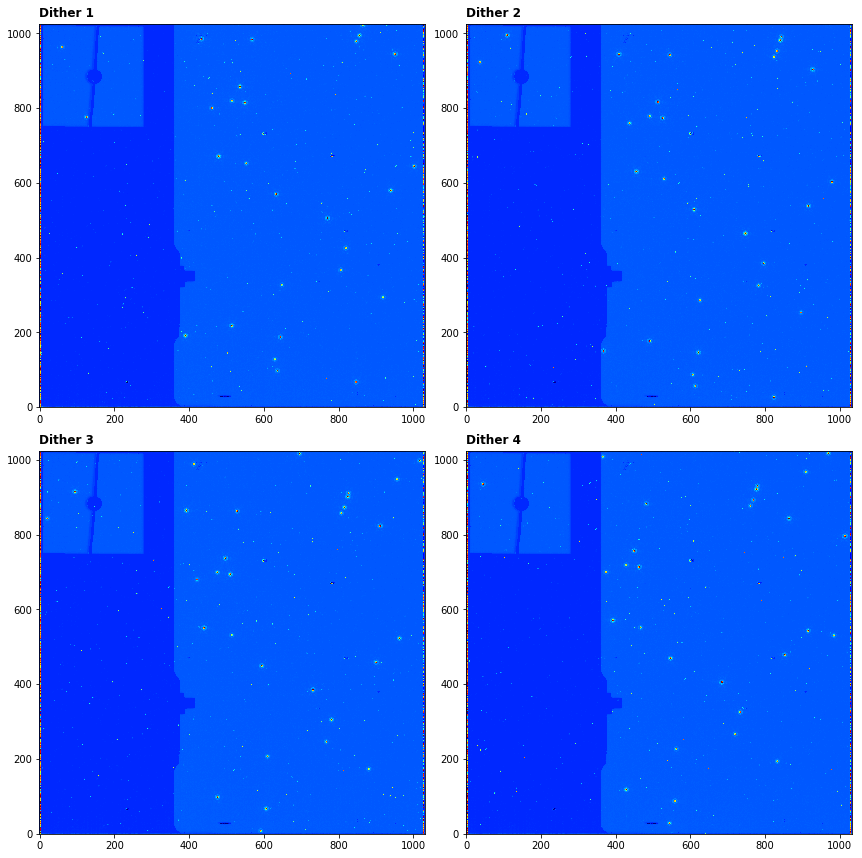

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:
        
        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=3e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [11]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'. Note that we must explicitly skip the IPC step.

There is an issue currently affecting the pipelining of MIRISim data through the refpix which is being looked into. For now, we just skip this step.


In [12]:
for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'refpix': {'skip': True}})
    

2019-01-30 16:30:38,543 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-01-30 16:30:38,545 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-01-30 16:30:38,548 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-01-30 16:30:38,550 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2019-01-30 16:30:38,552 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-01-30 16:30:38,556 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-01-30 16:30:38,559 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-01-30 16:30:38,562 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2019-01-30 16:30:38,564 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2019-01-30 16:30:38,566 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2019-

2019-01-30 16:32:21,056 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-01-30 16:32:21,065 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2019-01-30 16:32:21,110 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2019-01-30 16:32:23,024 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-01-30 16:32:23,906 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-01-30 16:32:28,201 - stpipe.Detector1Pipeline.jump - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/jump/twopoint_difference.py:83: RuntimeWarning: invalid value encountered in sqrt
  poisson_noise = np.sqrt(np.abs(med_diffs))

2019-01-30 16:32:43,696 - stpipe.Detector1Pipeline.jump - I

2019-01-30 16:39:41,191 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2019-01-30 16:39:41,192 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0023.fits'.
2019-01-30 16:39:41,193 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2019-01-30 16:39:41,194 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2019-01-30 16:39:41,196 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0009.fits'.
2019-01-30 16:39:41,197 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/m

2019-01-30 16:46:51,105 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:395: RuntimeWarning: divide by zero encountered in true_divide
  var_p3[num_int, :, :] = 1./ s_inv_var_p3[num_int, :, :]

2019-01-30 16:46:53,369 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:457: RuntimeWarning: divide by zero encountered in true_divide
  var_both3[num_int, :, :] = 1./s_inv_var_both3[num_int, :, :]

2019-01-30 16:46:59,823 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:487: RuntimeWarning: divide by zero encountered in true_divide
  slope_dataset2 = s_slope_by_var2/s_inv_var_both2

2019-01-30 16:47:00,155 - stpipe.Detector1Pipeline.ram

2019-01-30 16:47:49,888 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0023.fits
2019-01-30 16:47:51,453 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-01-30 16:47:51,526 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:47:51,572 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0022.fits
2019-01-30 16:47:52,472 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done
2019-01-30 16:47:52,540 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:47:52,540 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.
2019-01-30 16:47:52,541

2019-01-30 16:56:58,345 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 50
2019-01-30 16:56:58,347 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2019-01-30 16:56:59,078 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2019-01-30 16:56:59,331 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:56:59,409 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2019-01-30 16:56:59,410 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2019-01-30 16:56:59,412 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2019-01-30 16:56:59,521 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from det_image_seq3_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:56:59,585 - stpipe.Detector1Pipeline.gai

2019-01-30 16:58:43,636 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done
2019-01-30 16:58:43,729 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:58:44,646 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done
2019-01-30 16:58:44,797 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:58:44,991 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0058.fits
2019-01-30 16:58:45,142 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=50, nframes=1, groupgap=0
2019-01-30 16:58:45,143 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2019-01-30

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [13]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [14]:
from jwst.pipeline import Image2Pipeline
print(Image2Pipeline.__doc__)


    Image2Pipeline: Processes JWST imaging-mode slope data from Level-2a to
    Level-2b.

    Included steps are:
    background_subtraction, assign_wcs, flat_field, photom and resample.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Currently MIRISim is assigning an incorret value of 4 to the wcsaxes keyword in the datamodels. This is due to issues with displaying MIRISim output in applications like ds9. However, the incorrect value will cause an error at the level 3 stage in the resample step, which expects wcsaxes=2 for images. Therefore, we manually set wcsaxes to 2 in the call to Image2Pipeline so it propagates into the cal.fits output.

In [15]:
for f in level2A_files:
    with datamodels.open(f) as dm:
        dm.meta.wcsinfo.wcsaxes = 2
        Image2Pipeline.call(dm, output_use_model=True, save_results=True, output_dir=output_dir)
    

2019-01-30 17:06:14,046 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2019-01-30 17:06:14,056 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2019-01-30 17:06:14,065 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-01-30 17:06:14,067 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-01-30 17:06:14,069 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2019-01-30 17:06:14,072 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-01-30 17:06:14,148 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-01-30 17:06:14,178 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat

2019-01-30 17:06:18,190 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-01-30 17:06:18,191 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-01-30 17:06:18,193 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2019-01-30 17:06:18,195 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-01-30 17:06:18,272 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-01-30 17:06:18,301 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2019-01-30 17:06:18,311 -

2019-01-30 17:06:22,090 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2019-01-30 17:06:22,092 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-01-30 17:06:22,174 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-01-30 17:06:22,202 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2019-01-30 17:06:22,210 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits'.
2019-01-30 17:06:22,211 - stpipe.Image2Pipeline - I

2019-01-30 17:06:26,057 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-01-30 17:06:26,086 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2019-01-30 17:06:26,094 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits'.
2019-01-30 17:06:26,096 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2019-01-30 17:06:26,096 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2019-01-30 17:06:26,097 - stpipe.Ima

#### Quick check of the pipeline steps applied in the level 2B output. We'll look at the first dither:

In [16]:
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

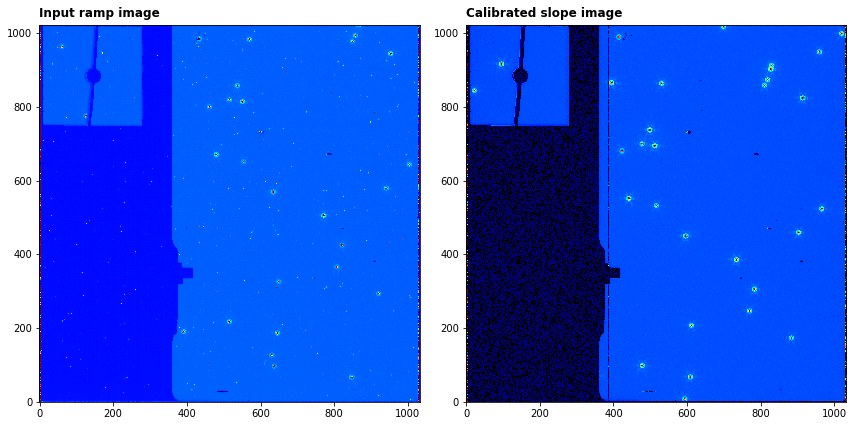

In [17]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=2e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=2, vmax=100))
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

### Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ('_cal.fits') produced by the level 2B pipeline. We can then combine the dithers with the Image3Pipeline. 

Note that, even though all steps will run in Image3Pipeline, the image alignment step is still not quite working as it should in jwst-0.9.6 so we will skip this step. We also skip the skymatch step as it seems to determine a large sky background from the images which, when subtracted, results in the majority of pixels in the FOV having negative values.

The output drizzled image file will be contained in '*_i2d.fits' with the source list contained in '*_cat.ecsv'. The source detection doesn't work particularly well with default parameters so snr_threshold and source fwhm is adjusted in the call to source_catalog.


#### create the level 3 association using the asn_from_list tool

In [18]:
call(["asn_from_list", "-o", "IMA_asn.json"] + level2B_files + ["--product-name", "ima_dither"])


0

#### import the level 3 pipeline class and print description

In [19]:
from jwst.pipeline import Image3Pipeline
print(Image3Pipeline.__doc__)


    Image3Pipeline: Applies level 3 processing to imaging-mode data from
                    any JWST instrument.

    Included steps are:
        tweakreg
        skymatch
        outlier_detection
        resample
        source_catalog
    


#### run pipeline

In [21]:
dm_3_container = datamodels.ModelContainer("IMA_asn.json")

Image3Pipeline.call(dm_3_container, save_results=True, output_dir=output_dir,
                    steps={'tweakreg':{'skip':True},
                           'skymatch':{'skip':True},
                           'source_catalog':{'save_results': True, 'kernel_fwhm': 5.0, 'snr_threshold': 20.}})



2019-01-30 17:13:34,402 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2019-01-30 17:13:34,405 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2019-01-30 17:13:34,407 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2019-01-30 17:13:34,410 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2019-01-30 17:13:34,413 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-01-30 17:13:34,416 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2019-01-30 17:13:34,552 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args (<ModelContainer>,).
2019-01-30 17:13:35,042 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['drizpars']
2019-01-30 17:13:35,049 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickk

In [22]:
# move the association file to the output directory
try:
    shutil.move('IMA_asn.json',os.path.join(output_dir,'IMA_asn.json'))
except:
    pass


#### plot the drizzled file

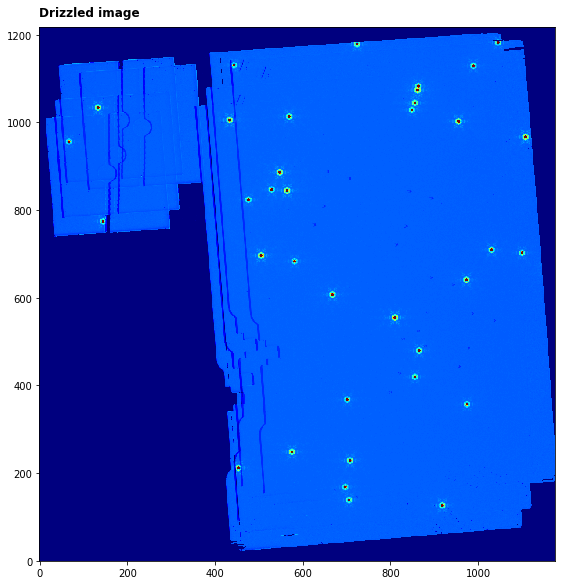

In [23]:
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0,vmax=20)
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

#### look at the source list 

In [24]:
from astropy.table import Table

my_catalog = os.path.join(output_dir,'ima_dither_cat.ecsv')
sources = Table.read(my_catalog, format='ascii.ecsv')

print(sources.columns)    # print all available column names
print()
sources['id', 'xcentroid', 'ycentroid', 'sky_centroid', 'abmag'].pprint(max_width=200)

<TableColumns names=('id','xcentroid','ycentroid','sky_centroid','area','source_sum','source_sum_err','semimajor_axis_sigma','semiminor_axis_sigma','orientation','sky_bbox_ll','sky_bbox_ul','sky_bbox_lr','sky_bbox_ur','orientation_sky','abmag','abmag_error')>

 id     xcentroid          ycentroid                    sky_centroid                    abmag       
           pix                pix                         deg,deg                                   
--- ------------------ ------------------ --------------------------------------- ------------------
  1  917.9060279833898 126.54070627194722  359.9719585728097,0.003918578545676947  15.34221363067627
  2  705.7413155165672 138.59190083200787  359.97846843324396,0.00429176738244304 15.615976333618164
  3   697.244425308664 168.32868006433455   359.9787291437619,0.00521262451036906  15.74244499206543
  4  453.6012794865591 211.75724109357577 359.98620485923027,0.006557474501949939 15.438608169555664
  5  707.8238765369771  228.6403

#### plot the source list over the drizzled image

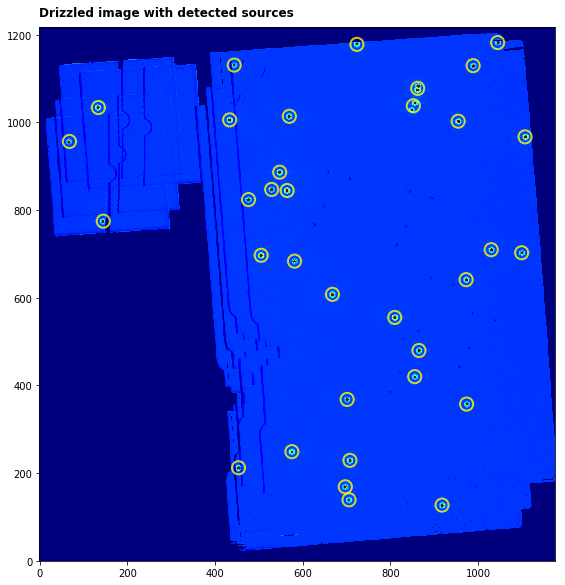

In [25]:
from astropy.table import Table
from photutils import CircularAperture

# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=15.)

# image
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=20)
apertures.plot(color='yellow', lw=2.0, alpha=0.8)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()